# XGB调参

In [ ]:
#https://blog.csdn.net/RuDing/article/details/78328835
#https://blog.csdn.net/weixin_41370083/article/details/79276887

In [ ]:
'''
XGBoost 的优势
Regularization： 
    标准的GBM并没有XGBoost的Regularization，这个能帮助减少过拟合问题
Parallel Processing: 
    XGBoost实现了并行计算，与GBM相比非常快
    但是基于序列的模型，新模型的建立是基于前面已经建立好的模型，如何能实现并行计算呢？探索一下吧
XGBoost 支持在Hadoop上实现
High Flexibility 
XGBoost允许用户定制优化目标和评价标准
这一点将会使得我们对模型有很多可以改进的地方
Handling Missing Values 
XGBoost有内嵌的处理缺失值的程序
其他模型中用户被要求为缺失值提供相应的与其他值不同的值去填充缺失值，XGBoost会尝试对缺失值进行分类，并学习这种分类
Tree Pruning: 
GBM会停止对一个节点进行分裂，当其计算到这个节点的split的loss是负数时，GBM是一个贪婪算法
XGBoost的分类取决于max_depth，当树的深度达到max_depth时，开始进行剪枝，移除没有正基尼（no positive gain）节点的split
另一个优点是一个节点被分裂的时候loss为-2，当其二次分裂的时候loss可能为+10，GBM会停止该节点的分裂，XGBoost会进入到第二步，然后结合两个分裂的影响，最终为+8
Built-in Cross-Validation 
XGBoost允许每一个交叉验证实现boosting过程，因而通过一次run就能获得boosting迭代的优化量
与GBM需要运营grid-search且需要限时值的范围获得优化量不同
Continue on Existing Model
用户可以通过上个版本的XGBoost模型训练新版本的模型
GBM的sklearn也有这个特性
加深对XGBoost的理解的文章： 
1.XGBoost Guide – Introduction to Boosted Trees 
2.Words from the Author of XGBoost


'''

In [ ]:
'''XGBoost Parameters
XGBoost的变量类型有三类：

    General Parameters：调控整个方程
    Booster Parameters：调控每步树的相关变量
    Learning Task Parameters：调控优化表现的变量
1.General Parameters：
    booster [default=gbtree]：

     gbtree: tree-based models，树模型
     gblinear: linear models，线性模型
    silent [default=0]:
        设置成1表示打印运行过程中的相关信息
        通常选择默认值就好，打印出的信息能够帮助理解model
    nthread [default to maximum number of threads available if not set] 
        主要用于并行计算，系统的内核数需要作为变量
        如果希望运行所有的内核，就不需要设置该参数，程序会自己检测到该值
2.Booster Parameters
虽然XGBoost有两种boosters,作者在参数这一块只讨论了tree booster，原因是tree booster的表现总是好于 linear booster

    eta [default=0.3] 
        与GBM中学习率的概念相似
        通过减小每一步的权重能够使得建立的模型更鲁棒
        通常最终的数值范围在[0.01-0.2]之间
    min_child_weight [default=1] 
        定义观测样本生成的孩子节点的权重最小和
        这个概念与GBM中的min_child_leaf概念类似，但是又不完全一样，这个概念指的是某观测叶子节点中所有样本权重之和的最小值，而GBM指的是叶子节点的最少样本量
        用于防止过拟合问题：较大的值能防止过拟合，过大的值会导致欠拟合问题
        需要通过CV调参
    max_depth [default=6] 
        树的最大深度
        用于防止过拟合问题
        通过CV调参
        通常值的范围：[3-10]
    max_leaf_nodes 
        一棵树最多的叶子节点的数目
        与max_depth定义一个就好
    gamma [default=0] 
        一个节点分裂的条件是其分裂能够起到降低loss function的作用，gamma 定义loss function降低多少才分裂
        这个变量使得算法变得保守，它的值取决于 loss function需要被调节
    max_delta_step [default=0] 
        此变量的设置使得我们定义每棵树的权重估计值的变化幅度。如果值为0，值的变化没有限制，如果值>0，权重的变化将会变得相对保守
        通常这个参数不会被使用，但如果是极度不平衡的逻辑回归将会有所帮助
    subsample [default=1]： 
        与GBM的subsample定义一样，指的是没有每棵树的样本比例
        低值使得模型更保守且能防止过拟合，但太低的值会导致欠拟合
        通常取值范围[0.5-1]
    colsample_bytree [default=1] 
        与GBM中的max_features类似，指的是每棵树随机选取的特征的比例
        通常取值范围[0.5-1]
    colsample_bylevel [default=1] 
        指的是树的每个层级分裂时子样本的特征所占的比例
        作者表示不用这个参数，因为subsample和colsample_bytree组合做的事与之类似
    lambda [default=1] 
        l2正则化权重的术语（同 Ridge regression）
        用于处理XGBoost里的正则化部分，虽然很多数据科学家不怎么使用这个参数，但是它可以用于帮助防止过拟合
    alpha [default=0] 
        l1正则化的权重术语（同Lasso regression）
        当特征量特别多的时候可以使用，这样能加快算法的运行效率
    scale_pos_weight [default=1] 
        当样本不平衡时，需要设置一个大于0的数帮助算法尽快收敛
3.Learning Task Parameters
此类变量用于定义优化目标每一次计算的需要用到的变量

    objective [default=reg:linear] 
        用于定义loss function，通常有以下几类
        binary:logistic-用于二分类，返回分类的概率而不是类别（class）
        multi:softmax-多分类问题，返回分类的类别而不是概率
        multi:softprob-与softmax类似，但是返回样本属于每一类的概率
    eval_metric [ default according to objective ] 
        这个变量用于 测试数据（validation data.）
        默认值：回归-rmse；分类-error
        通常值如下： 
            rmse – root mean square error
            mae – mean absolute error
            logloss – negative log-likelihood
            error – Binary classification error rate (0.5 threshold)
            merror – Multiclass classification error rate
            mlogloss – Multiclass logloss
            auc: Area under the curve
    seed [default=0] 
        随机种子的值
有些变量在Python的sklearn的接口中对应命名如下： 
1. eta -> learning rate 
2. lambda ->reg_lambda 
3. alpha -> reg_alpha'''

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn.datasets
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import pandas as pd

In [8]:
#数据载入
X,y=sklearn.datasets.make_hastie_10_2(random_state=0)
X.shape

(12000, 10)

In [10]:
X_df=pd.DataFrame(X,columns=['a','b','c','d','e','f','g','h','i','j'])
y_df=pd.DataFrame(y,columns=['y'])

In [11]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
a    12000 non-null float64
b    12000 non-null float64
c    12000 non-null float64
d    12000 non-null float64
e    12000 non-null float64
f    12000 non-null float64
g    12000 non-null float64
h    12000 non-null float64
i    12000 non-null float64
j    12000 non-null float64
dtypes: float64(10)
memory usage: 937.6 KB


In [12]:
X_train,X_test,y_train,y_test=train_test_split(X_df,y_df,test_size=0.5,random_state=0)

### 默认参数下的AUC值和Accuracy

In [13]:
auc_score=[]
accuracy=[]
clf=XGBClassifier()
clf.fit(X_train,y_train)

D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [14]:
y_pre=clf.predict(X_test)
y_pre

array([ 1.,  1., -1., ..., -1.,  1., -1.])

In [15]:
y_pro=clf.predict_proba(X_test)[:,1]

y_pro

array([0.6235448 , 0.68954515, 0.21596238, ..., 0.26699007, 0.94158596,
       0.37172532], dtype=float32)

In [16]:
clf.predict_proba(X_test)

array([[0.3764552 , 0.6235448 ],
       [0.31045485, 0.68954515],
       [0.7840376 , 0.21596238],
       ...,
       [0.73300993, 0.26699007],
       [0.05841404, 0.94158596],
       [0.6282747 , 0.37172532]], dtype=float32)

In [19]:
print('AUC score:{}'.format(metrics.roc_auc_score(y_test,y_pro)))
print('ACCURACY :{}'.format(metrics.accuracy_score(y_test,y_pre)))
print('Accuracy:{}'.format(clf.score(X_test,y_test)))
auc_score.append(metrics.roc_auc_score(y_test,y_pro))
accuracy.append(metrics.accuracy_score(y_test,y_pre))

AUC score:0.9724236044936388
ACCURACY :0.8993333333333333
Accuracy:0.8993333333333333


In [22]:
auc_score

[0.9724236044936388]

### 调参1

In [24]:
clf = XGBClassifier(
    learning_rate =0.1, #默认0.3
    n_estimators=1000, #树的个数
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', #逻辑回归损失函数
    nthread=4,  #cpu线程数
    scale_pos_weight=1,
    seed=27)
clf.fit(X_train,y_train)
y_pre=clf.predict(X_test)
y_pro=clf.predict_proba(X_test)[:,1]
print('AUC score:{}'.format(metrics.roc_auc_score(y_test,y_pro)))
print('ACCURACY :{}'.format(metrics.accuracy_score(y_test,y_pre)))
print('Accuracy:{}'.format(clf.score(X_test,y_test)))
auc_score.append(metrics.roc_auc_score(y_test,y_pro))
accuracy.append(metrics.accuracy_score(y_test,y_pre))

D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC score:0.989543258119342
ACCURACY :0.9436666666666667
Accuracy:0.9436666666666667


### 调参2

In [ ]:
'''第二步： max_depth 和 min_weight 它们对最终结果有很大的影响

max_depth range(3,10,2)=[3, 5, 7, 9]

min_weight range(1,6,2)=[1, 3, 5]

max_depth=3 min_weight=1 最好'''

In [25]:
clf = XGBClassifier(
    learning_rate =0.1, #默认0.3
    n_estimators=1000, #树的个数
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', #逻辑回归损失函数
    nthread=4,  #cpu线程数
    scale_pos_weight=1,
    seed=27)
clf.fit(X_train,y_train)
y_pre=clf.predict(X_test)
y_pro=clf.predict_proba(X_test)[:,1]
print('AUC score:{}'.format(metrics.roc_auc_score(y_test,y_pro)))
print('ACCURACY :{}'.format(metrics.accuracy_score(y_test,y_pre)))
print('Accuracy:{}'.format(clf.score(X_test,y_test)))
auc_score.append(metrics.roc_auc_score(y_test,y_pro))
accuracy.append(metrics.accuracy_score(y_test,y_pre))

D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC score:0.9916984305331351
ACCURACY :0.9485
Accuracy:0.9485


### 调参3

In [26]:
'''第三步：gamma参数调优

'gamma':[i/10.0 for i in range(0,7)]=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

gamma=0.5 最好'''

"第三步：gamma参数调优\n\n'gamma':[i/10.0 for i in range(0,7)]=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]\n\ngamma=0.5 最好"

In [27]:
clf = XGBClassifier(
    learning_rate =0.1, #默认0.3
    n_estimators=1000, #树的个数
    max_depth=3,
    min_child_weight=1,
    gamma=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', #逻辑回归损失函数
    nthread=4,  #cpu线程数
    scale_pos_weight=1,
    seed=27)
clf.fit(X_train,y_train)
y_pre=clf.predict(X_test)
y_pro=clf.predict_proba(X_test)[:,1]
print('AUC score:{}'.format(metrics.roc_auc_score(y_test,y_pro)))
print('ACCURACY :{}'.format(metrics.accuracy_score(y_test,y_pre)))
print('Accuracy:{}'.format(clf.score(X_test,y_test)))
auc_score.append(metrics.roc_auc_score(y_test,y_pro))
accuracy.append(metrics.accuracy_score(y_test,y_pre))

D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC score:0.9921074421672438
ACCURACY :0.9495
Accuracy:0.9495


### 调参4

In [28]:
'''第四步：调整subsample 和 colsample_bytree 参数

'subsample':[i/10.0 for i in range(6,10)]=[0.6, 0.7, 0.8, 0.9]

'colsample_bytree':[i/10.0 for i in range(6,10)]=[0.6, 0.7, 0.8, 0.9]

'subsample': 0.6, 'colsample_bytree': 0.6 最好
'''

"第四步：调整subsample 和 colsample_bytree 参数\n\n'subsample':[i/10.0 for i in range(6,10)]=[0.6, 0.7, 0.8, 0.9]\n\n'colsample_bytree':[i/10.0 for i in range(6,10)]=[0.6, 0.7, 0.8, 0.9]\n\n'subsample': 0.6, 'colsample_bytree': 0.6 最好\n"

In [29]:
clf = XGBClassifier(
    learning_rate =0.1, #默认0.3
    n_estimators=1000, #树的个数
    max_depth=3,
    min_child_weight=1,
    gamma=0.5,
    subsample=0.6,
    colsample_bytree=0.6,
    objective= 'binary:logistic', #逻辑回归损失函数
    nthread=4,  #cpu线程数
    scale_pos_weight=1,
    seed=27)
clf.fit(X_train,y_train)
y_pre=clf.predict(X_test)
y_pro=clf.predict_proba(X_test)[:,1]
print('AUC score:{}'.format(metrics.roc_auc_score(y_test,y_pro)))
print('ACCURACY :{}'.format(metrics.accuracy_score(y_test,y_pre)))
print('Accuracy:{}'.format(clf.score(X_test,y_test)))
auc_score.append(metrics.roc_auc_score(y_test,y_pro))
accuracy.append(metrics.accuracy_score(y_test,y_pre))

D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC score:0.9926972367214
ACCURACY :0.9548333333333333
Accuracy:0.9548333333333333


### 调参5

In [30]:
''''reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]=[1e-05, 0.01, 0.1, 1, 100] 默认0 L1正则项参数，参数值越大，模型越不容易过拟合

'reg_lambda':[1,5,10,50] 默认1L2正则项参数，参数值越大，模型越不容易过拟合

{'reg_alpha': 1e-05, 'reg_lambda': 1} 正则变化不大
'''

"'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]=[1e-05, 0.01, 0.1, 1, 100] 默认0 L1正则项参数，参数值越大，模型越不容易过拟合\n\n'reg_lambda':[1,5,10,50] 默认1L2正则项参数，参数值越大，模型越不容易过拟合\n\n{'reg_alpha': 1e-05, 'reg_lambda': 1} 正则变化不大\n"

In [32]:
clf = XGBClassifier(
    learning_rate =0.1, #默认0.3
    n_estimators=1000, #树的个数
    max_depth=3,
    min_child_weight=1,
    gamma=0.5,
    subsample=0.6,
    colsample_bytree=0.6,
    objective= 'binary:logistic', #逻辑回归损失函数
    nthread=4,  #cpu线程数
    scale_pos_weight=1,
    reg_alpha=1e-05,
    reg_lambda=1,
    seed=27)
clf.fit(X_train,y_train)
y_pre=clf.predict(X_test)
y_pro=clf.predict_proba(X_test)[:,1]
print('AUC score:{}'.format(metrics.roc_auc_score(y_test,y_pro)))
print('ACCURACY :{}'.format(metrics.accuracy_score(y_test,y_pre)))
print('Accuracy:{}'.format(clf.score(X_test,y_test)))
auc_score.append(metrics.roc_auc_score(y_test,y_pro))
accuracy.append(metrics.accuracy_score(y_test,y_pre))

D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC score:0.9927470159151193
ACCURACY :0.953
Accuracy:0.953


### 调参6

In [33]:
'''进一步 降低学习速率 增加更多的树

'learning_rate':[0.01,0.1,0.3]

'learning_rate': 0.1 不变

'n_estimators':[1000,1200,1500,2000,2500]

'n_estimators': 2000 较好'''

"进一步 降低学习速率 增加更多的树\n\n'learning_rate':[0.01,0.1,0.3]\n\n'learning_rate': 0.1 不变\n\n'n_estimators':[1000,1200,1500,2000,2500]\n\n'n_estimators': 2000 较好"

In [34]:
clf = XGBClassifier(
    learning_rate =0.1, #默认0.3
    n_estimators=2000, #树的个数
    max_depth=3,
    min_child_weight=1,
    gamma=0.5,
    subsample=0.6,
    colsample_bytree=0.6,
    objective= 'binary:logistic', #逻辑回归损失函数
    nthread=4,  #cpu线程数
    scale_pos_weight=1,
    reg_alpha=1e-05,
    reg_lambda=1,
    seed=27)
clf.fit(X_train,y_train)
y_pre=clf.predict(X_test)
y_pro=clf.predict_proba(X_test)[:,1]
print('AUC score:{}'.format(metrics.roc_auc_score(y_test,y_pro)))
print('ACCURACY :{}'.format(metrics.accuracy_score(y_test,y_pre)))
print('Accuracy:{}'.format(clf.score(X_test,y_test)))
auc_score.append(metrics.roc_auc_score(y_test,y_pro))
accuracy.append(metrics.accuracy_score(y_test,y_pre))

D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\mathwork\anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC score:0.993322810071042
ACCURACY :0.9581666666666667
Accuracy:0.9581666666666667


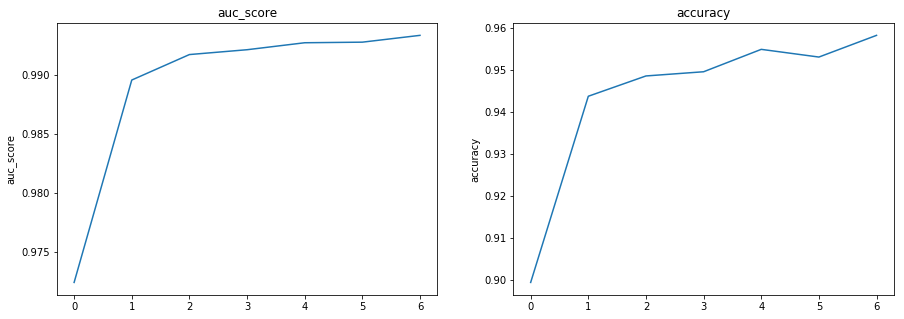

In [36]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,5))
p1=plt.subplot(1,2,1)
p1.plot(auc_score)
p1.set_ylabel('auc_score')
p1.set_title('auc_score')
p2=plt.subplot(1,2,2)
p2.plot(accuracy)
p2.set_ylabel('accuracy')
p2.set_title('accuracy')
plt.show()